In [35]:
import re
import pandas as pd
import matplotlib.pyplot as plt


In [36]:
SYSTEM_LOG = "../logs/benchmark_usage_8d8e0.log"

with open(SYSTEM_LOG) as f:
    lines = [line.strip() for line in f if line.strip()]


In [37]:
cpu_samples = []
mem_samples = []
markers = []

cpu_re = re.compile(r"all\s+[\d.]+\s+[\d.]+\s+[\d.]+\s+[\d.]+\s+[\d.]+\s+([\d.]+)$")

cpu_idx = 0
mem_idx = 0

for i, line in enumerate(lines):
    # Experiment markers
    if line.endswith("Start") or line.endswith("End"):
        markers.append((i, line))
        continue

    # CPU sample
    if " all " in line and "CPU" not in line:
        m = cpu_re.search(line)
        if m:
            idle = float(m.group(1))
            cpu_samples.append({
                "cpu_line": i,
                "idx": cpu_idx,
                "cpu_used": 100 - idle
            })
            cpu_idx += 1

    # Memory sample (%memused is column 5)
    if "kbmemfree" not in line and " AM " in line:
        parts = line.split()
        if len(parts) >= 6:
            try:
                mem_used = float(parts[5])
                mem_samples.append({
                    "idx": mem_idx,
                    "mem_used": mem_used
                })
                mem_idx += 1
            except ValueError:
                pass


In [38]:
cpu_df = pd.DataFrame(cpu_samples).sort_values("idx")
mem_df = pd.DataFrame(mem_samples).sort_values("idx")

df = pd.merge_asof(
    cpu_df,
    mem_df,
    on="idx",
    direction="nearest"
)


In [39]:
events = []

for line_idx, label in markers:
    name, phase = label.rsplit(" ", 1)
    events.append({"line": line_idx, "name": name, "phase": phase})

events_df = pd.DataFrame(events)

experiment_ranges = []

for name in events_df["name"].unique():
    starts = events_df[(events_df.name == name) & (events_df.phase == "Start")]
    ends = events_df[(events_df.name == name) & (events_df.phase == "End")]

    for s, e in zip(starts.line.values, ends.line.values):
        experiment_ranges.append((name, s, e))


In [40]:
WINDOW = 5
platform_curves = {}

for name, start_line, end_line in experiment_ranges:
    exp = df[
        (df.cpu_line >= start_line) &
        (df.cpu_line <= end_line)
    ].copy()

    if len(exp) < WINDOW:
        continue

    exp["cpu_avg"] = exp["cpu_used"].rolling(WINDOW).mean()
    exp["mem_avg"] = exp["mem_used"].rolling(WINDOW).mean()
    exp = exp.dropna()

    exp["progress"] = (
        (exp.index - exp.index.min()) /
        (exp.index.max() - exp.index.min())
    ) * 100

    platform_curves[name] = exp


In [42]:
SEDONA_LOG = "../logs/benchmark_usage_8d8e0_sedona.log"

sedona_rows = []

sedona_re = re.compile(
    r"avg_cpu_pct=([\d.]+), peak_mem_pct=([\d.]+)"
)

with open(SEDONA_LOG) as f:
    for i, line in enumerate(f):
        m = sedona_re.search(line)
        if m:
            sedona_rows.append({
                "idx": i,
                "cpu_used": float(m.group(1)),
                "mem_used": float(m.group(2))
            })

sedona_df = pd.DataFrame(sedona_rows)


In [43]:
sedona_df["progress"] = (
    sedona_df.index / (len(sedona_df) - 1)
) * 100


In [44]:
platform_curves["Sedona"] = sedona_df


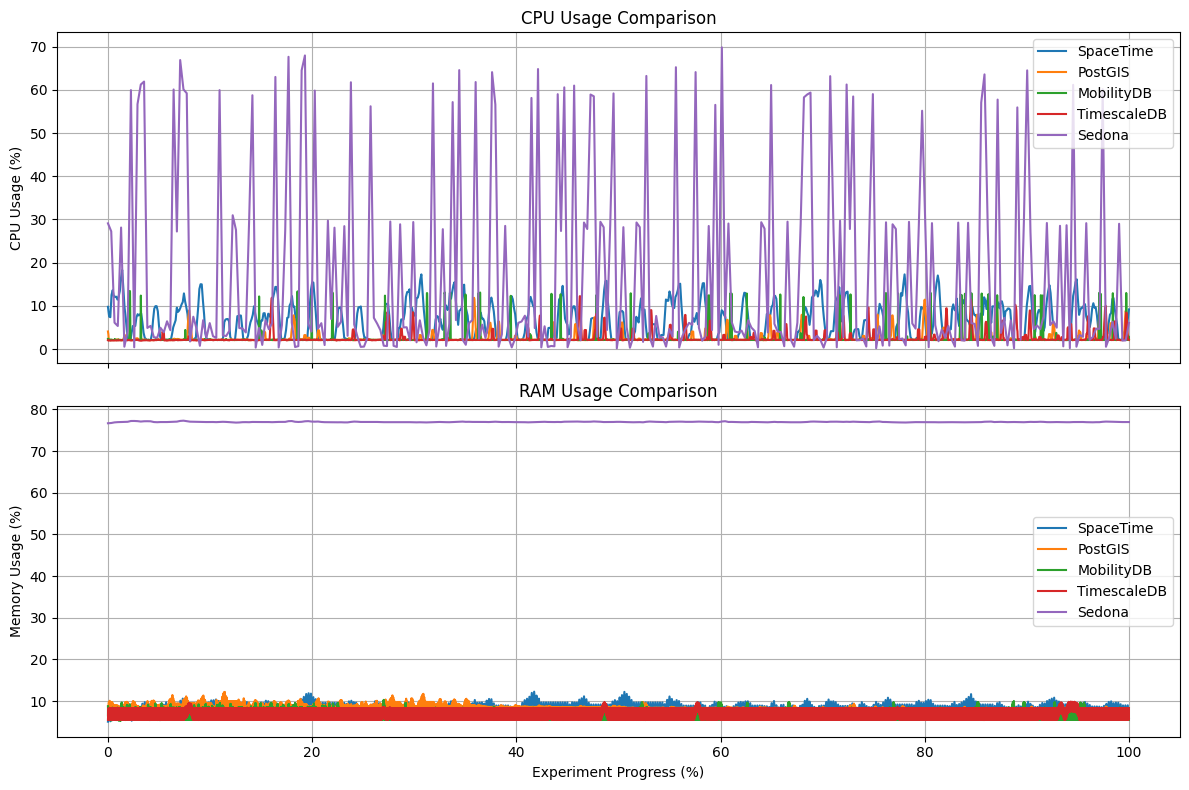

In [47]:
fig, (ax_cpu, ax_mem) = plt.subplots(
    2, 1, figsize=(12, 8), sharex=True
)

# CPU
for name, data in platform_curves.items():
    ax_cpu.plot(
        data["progress"],
        data["cpu_used"] if name == "Sedona" else data["cpu_avg"],
        label=name
    )

ax_cpu.set_title("CPU Usage Comparison")
ax_cpu.set_ylabel("CPU Usage (%)")
ax_cpu.grid(True)
ax_cpu.legend()

# Memory
for name, data in platform_curves.items():
    ax_mem.plot(
        data["progress"],
        data["mem_used"] if name == "Sedona" else data["mem_avg"],
        label=name
    )

ax_mem.set_title("RAM Usage Comparison")
ax_mem.set_xlabel("Experiment Progress (%)")
ax_mem.set_ylabel("Memory Usage (%)")
ax_mem.grid(True)
ax_mem.legend()

plt.tight_layout()
plt.savefig("platform_usage_comparison.pdf", bbox_inches='tight')
plt.show()


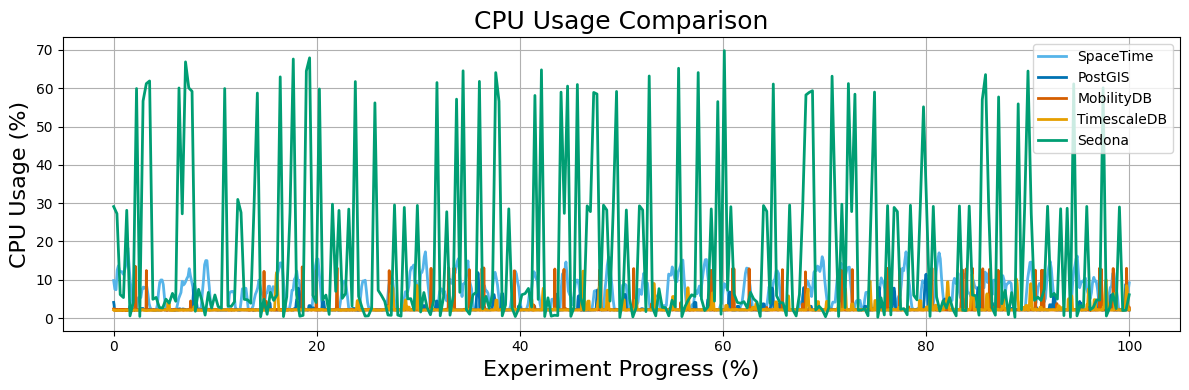

In [ ]:
# Fixed color palette for platforms
PLATFORM_COLORS = {
    "PostGIS": "#0072B2",
    "TimescaleDB": "#E69F00",
    "Sedona": "#009E73",
    "SpaceTime": "#56B4E9",               # lighter blue
    "MobilityDB": "#D55E00",
    "MobilityDB_Time_Partitioned": "#228833",
    "MobilityDB_Space_Partitioned": "#CC79A7",
}

# Plot CPU usage
fig, ax_cpu = plt.subplots(1, 1, figsize=(12, 4))

for name, data in platform_curves.items():
    color = PLATFORM_COLORS.get(name, "#333333")  # fallback gray if not in palette
    ax_cpu.plot(
        data["progress"],
        data["cpu_used"] if name == "Sedona" else data["cpu_avg"],
        label=name,
        color=color,
        linewidth=2
    )

ax_cpu.set_title("CPU Usage Comparison", fontsize=18)
ax_cpu.set_ylabel("CPU Usage (%)", fontsize=16)
ax_cpu.set_xlabel("Experiment Progress (%)", fontsize=16)
ax_cpu.grid(True)
ax_cpu.legend(title="Platform", fontsize=18)
plt.tight_layout()
plt.savefig("cpu_usage_comparison.pdf", bbox_inches='tight')
plt.show()


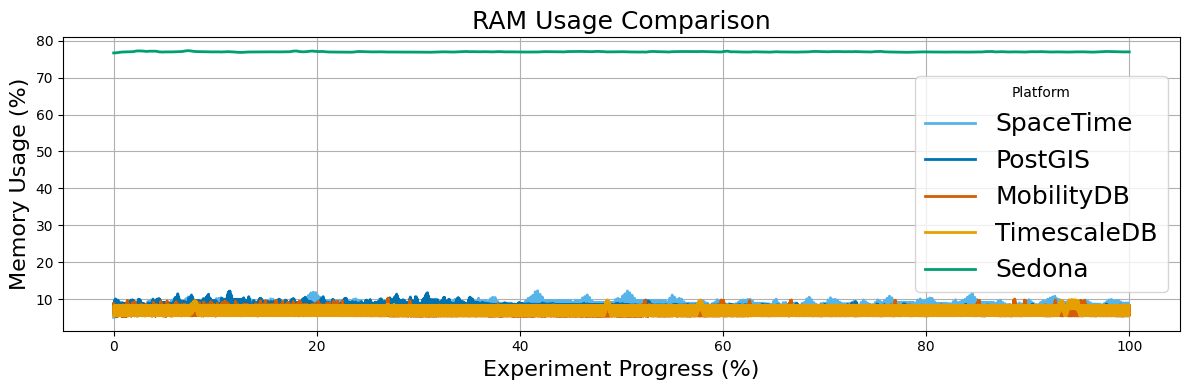

In [59]:
import matplotlib.pyplot as plt

# Fixed color palette for platforms
PLATFORM_COLORS = {
    "PostGIS": "#0072B2",
    "TimescaleDB": "#E69F00",
    "Sedona": "#009E73",
    "SpaceTime": "#56B4E9",
    "MobilityDB": "#D55E00",
    "MobilityDB_Time_Partitioned": "#228833",
    "MobilityDB_Space_Partitioned": "#CC79A7",
}

# Plot RAM usage
fig, ax_mem = plt.subplots(1, 1, figsize=(12, 4))

for name, data in platform_curves.items():
    color = PLATFORM_COLORS.get(name, "#333333")  # fallback gray
    ax_mem.plot(
        data["progress"],
        data["mem_used"] if name == "Sedona" else data["mem_avg"],
        label=name,
        color=color,
        linewidth=2
    )

ax_mem.set_title("RAM Usage Comparison", fontsize=18)
ax_mem.set_xlabel("Experiment Progress (%)", fontsize=16)
ax_mem.set_ylabel("Memory Usage (%)", fontsize=16)
ax_mem.grid(True)
ax_mem.legend(title="Platform", fontsize=18)

plt.tight_layout()
plt.savefig("ram_usage_comparison.pdf", bbox_inches='tight')
plt.show()


In [49]:
avg_ram_usage = []

for name, data in platform_curves.items():
    if name == "Sedona":
        avg_mem = data["mem_used"].mean()
        metric = "avg_peak_mem_pct"
    else:
        avg_mem = data["mem_avg"].mean()
        metric = "avg_memused_pct"

    avg_ram_usage.append({
        "platform": name,
        "average_ram_usage_pct": avg_mem,
        "metric_type": metric
    })

avg_ram_df = pd.DataFrame(avg_ram_usage).sort_values(
    "average_ram_usage_pct",
    ascending=False
)

avg_ram_df


,platform,average_ram_usage_pct,metric_type
4,Sedona,76.998590,avg_peak_mem_pct
0,SpaceTime,7.983512,avg_memused_pct
1,PostGIS,7.412179,avg_memused_pct
3,TimescaleDB,6.935121,avg_memused_pct
2,MobilityDB,6.926093,avg_memused_pct
